# Spotify Wrapped

Every December since 2016, Spotify users discover their "Spotify Wrapped". The latter provides a compilation of data about their activity on the platform over the past year: top artists, top songs, top genres, etc. 

My objective here is to reproduce most insights from Spotify Wrapped using Python (data import, data visualization) and SQL (data analysis). To do so, I requested all my Spotify user data from the app in November 2022. 

Note: The SQL statements are written here thanks to Python sqlite3 package. The SQL syntax may change a little bit compared to MYSQL or POSTGRESQL languages (especially as far as date variables are concerned).

In [1]:
# Import all relevant Python packages

    # Data processing
import glob
import os
import pandas as pd
import numpy as np
import json
import string
import sqlite3

    # Data visualization & dashboarding
import matplotlib.pyplot as plt
import seaborn as sns
import panel as pn
pn.extension('tabulator')
import hvplot.pandas 


## 1. Import and prepare the Spotify data (JSON files)

*Objective* : I received my Spotify data in different batches (8 JSON files). My goal is to import all of them at once in a Pandas dataframe, and remove every private information (IP address, device information, etc).  
*To do so, I was inspired by the Stackoverflow thread* : https://stackoverflow.com/questions/41857659/python-pandas-add-filename-column-csv

### 1.1. Importing the data

In [2]:
# Step 1 : I look for all JSON files available in my Windows folder (where I stored my Spotify data)

path_to_json = 'C:/Users/margo/Documents/Documents/Formation/Github/Spotify/MyData/' #local path to my JSON files folder 
json_pattern = os.path.join(path_to_json,'*.json') #looking for every JSON file in the folder
globbed_files = glob.glob(json_pattern) #listing all the JSON files paths
globbed_files

['C:/Users/margo/Documents/Documents/Formation/Github/Spotify/MyData\\endsong_0.json',
 'C:/Users/margo/Documents/Documents/Formation/Github/Spotify/MyData\\endsong_1.json',
 'C:/Users/margo/Documents/Documents/Formation/Github/Spotify/MyData\\endsong_2.json',
 'C:/Users/margo/Documents/Documents/Formation/Github/Spotify/MyData\\endsong_3.json',
 'C:/Users/margo/Documents/Documents/Formation/Github/Spotify/MyData\\endsong_4.json',
 'C:/Users/margo/Documents/Documents/Formation/Github/Spotify/MyData\\endsong_5.json',
 'C:/Users/margo/Documents/Documents/Formation/Github/Spotify/MyData\\endsong_6.json',
 'C:/Users/margo/Documents/Documents/Formation/Github/Spotify/MyData\\endvideo.json']

In [3]:
# Step 2: I open and read every JSON file from all the file paths listed before thanks to a for loop. 
   # I also add a column "filename" that contains the name of each file
   # Finally, I store all data in a "data" list

data = [] # empty list (initialization) 
for json in globbed_files:
    frame = pd.read_json(json) 
    frame['filename'] = os.path.basename(json) 
    data.append(frame) 

In [4]:
# Step 3: Export the data to csv format
bigframe = pd.concat(data, ignore_index=True) #dont want pandas to try an align row indexes
bigframe.to_csv("spotify_data.csv", sep = ';')

C:\Users\margo\AppData\Local\Temp\ipykernel_4176\1933132580.py:2: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  bigframe = pd.concat(data, ignore_index=True) #dont want pandas to try an align row indexes


### 1.2. Preparing the data

In [5]:
# Step 4 : Remove private information  
spotify_data = pd.read_csv("spotify_data.csv", sep = ';', index_col = 0)

# Blur device information
spotify_data["device"] = spotify_data["platform"].str[:10]

# Delete columns that share private information (username, IP address, etc)
to_delete = ['username', 'ip_addr_decrypted', 'user_agent_decrypted', 'platform']
spotify_data.drop(to_delete, axis=1, inplace=True)

In [6]:
# Step 5 : Add variables that will be useful for data analysis
# Time variables
spotify_data['year'] = pd.to_datetime(spotify_data['ts']).dt.strftime('%Y')
spotify_data['year_month'] = pd.to_datetime(spotify_data['ts']).dt.strftime('%Y-%m')
spotify_data['month'] = pd.to_datetime(spotify_data['ts']).dt.strftime('%m')
spotify_data["date"] = pd.to_datetime(spotify_data["ts"]).dt.strftime('%Y-%m-%d')
spotify_data["hour"] = pd.to_datetime(spotify_data["ts"]).dt.strftime('%H')

# Durations
spotify_data["sec_played"] = round(spotify_data["ms_played"]/1000,4) #Convert milliseconds to seconds
spotify_data["min_played"] = round(spotify_data["ms_played"]/1000/60,2) #Convert milliseconds to minutes

# Music vs podcast
spotify_data["type"] = np.where(~spotify_data["spotify_track_uri"].isnull(), "Music", 
                                np.where(~spotify_data["spotify_episode_uri"].isnull(), "Podcast", "Error")
                               )

In [7]:
# Step 6: Rename some variables whose names are too long
spotify_data = spotify_data.rename(columns = {'master_metadata_track_name' : 'track_name',
                                   'master_metadata_album_artist_name' : 'artist_name',
                                   'master_metadata_album_album_name' : 'album_name'
                                             })

#End results
pd.set_option('display.max_columns', None)
spotify_data.sort_values('ts', ascending = False).head(5)

,ts,ms_played,conn_country,track_name,artist_name,album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,filename,device,year,year_month,month,date,hour,sec_played,min_played,type
61375,2022-11-24T22:42:26Z,788584,FR,NaN,NaN,NaN,NaN,Journal 07h00 du mardi 22 novembre 2022,Journal de 07h00,spotify:episode:4Adwt7pETOXPNplhooHLa1,clickrow,endplay,False,NaN,0.0,1.669328e+12,False,endsong_3.json,Android OS,2022,2022-11,11,2022-11-24,22,788.584,13.14,Podcast
88700,2022-11-24T22:18:34Z,155703,FR,Dancing With The Devil,ISBANKY,Dancing With The Devil,spotify:track:0ChUbF2A6VjPVRFOKJ8VSN,NaN,NaN,NaN,trackdone,logout,False,NaN,0.0,1.669325e+12,False,endsong_5.json,Android OS,2022,2022-11,11,2022-11-24,22,155.703,2.60,Music
36788,2022-11-24T21:29:29Z,123750,FR,Pharaoh's Wrath,Feerix,Pharaoh's Wrath,spotify:track:1XQQwnbfGqezphAHjaVxXR,NaN,NaN,NaN,trackdone,trackdone,False,NaN,0.0,1.669325e+12,False,endsong_2.json,Android OS,2022,2022-11,11,2022-11-24,21,123.750,2.06,Music
7564,2022-11-24T21:27:24Z,187306,FR,Ma solitude,Kendji Girac,Ensemble,spotify:track:2lZW1J1ScVcV8qHMkHN64u,NaN,NaN,NaN,clickrow,trackdone,False,NaN,0.0,1.669325e+12,False,endsong_0.json,Android OS,2022,2022-11,11,2022-11-24,21,187.306,3.12,Music
89308,2022-11-24T21:24:18Z,17268,FR,Poison Love,Dreamcatcher,[Dystopia : Road to Utopia],spotify:track:7C3cUybMDDF7PKyFcDWouF,NaN,NaN,NaN,trackdone,endplay,False,NaN,0.0,1.669325e+12,False,endsong_5.json,Android OS,2022,2022-11,11,2022-11-24,21,17.268,0.29,Music


## 2. Set up the SQL connection

*Objective* : The spotify_data dataframe will be analyzed thanks to SQL queries. The goal is indeed to mimick data analysis in a Datawharehouse like Teradata or Google Big Query. To do so, I must create a SQL connection beforehand.

In [8]:
# Create the SQLITE3 connection
cnx = sqlite3.connect(':memory:')

# Transform the Pandas dataframe "spotify_data" to a SQL table "spotify"
spotify_data.to_sql(name='spotify', con=cnx)

97998

## 3. Understand the dataset

*Objective*: I perform some simple queries to better understand the dataset I retrieved in the previous steps. The goal is to answer some simple questions:
* What is the total volumetry? How is it distributed per JSON file and year ?
* What is the period considered (min and max dates) ?

In [9]:
# Total volumetry: About 100k rows in total
volumetry = pd.read_sql('''SELECT COUNT(*) AS nb_rows 
                        FROM spotify''', cnx)
volumetry

,nb_rows
0,97998


In [10]:
# Volumetry per file: 
    # Every JSON file contains about 15,800 rows (except the video and last endsong files)
    # The data span from February 2020 to end November 2022
    # Each file contains about the same proportion of music tracks (98%) / podcasts episodes (2%) 
    # - except the endvideo file that contains only video podcasts
volumetry_file = pd.read_sql('''SELECT filename, 
                                 MIN(date) AS min_date,
                                 MAX(date) AS max_date,
                                 COUNT(*) AS nb_rows,
                                 SUM(CASE WHEN track_name IS NOT NULL THEN 1 ELSE 0 END) AS music_tracks,
                                 SUM(CASE WHEN episode_name IS NOT NULL THEN 1 ELSE 0 END) AS podcast_eps,
                                 ROUND(CAST(SUM(CASE WHEN track_name IS NOT NULL THEN 1 ELSE 0 END) AS FLOAT)
                                   / CAST(COUNT(*) AS FLOAT),2) AS pct_music_tracks,
                                 ROUND(CAST(SUM(CASE WHEN episode_name IS NOT NULL THEN 1 ELSE 0 END) AS FLOAT) /
                                 CAST(COUNT(*) AS FLOAT), 2) AS pct_podcast
                             FROM spotify
                             GROUP BY 1''', cnx)

volumetry_file

,filename,min_date,max_date,nb_rows,music_tracks,podcast_eps,pct_music_tracks,pct_podcast
0,endsong_0.json,2020-02-02,2022-11-24,15851,15485,357,0.98,0.02
1,endsong_1.json,2020-02-02,2022-11-24,15855,15510,332,0.98,0.02
2,endsong_2.json,2020-02-02,2022-11-24,15849,15509,322,0.98,0.02
3,endsong_3.json,2020-02-02,2022-11-24,15838,15507,317,0.98,0.02
4,endsong_4.json,2020-02-02,2022-11-24,15834,15504,320,0.98,0.02
5,endsong_5.json,2020-02-02,2022-11-24,15833,15472,351,0.98,0.02
6,endsong_6.json,2020-02-03,2022-11-24,2900,2849,51,0.98,0.02
7,endvideo.json,2021-07-30,2022-11-22,38,0,38,0.00,1.00


<div class="alert alert-block alert-info">
<b>Learnings:</b> <b> In total, my Spotify data are stored quite evenly across 8 JSON files, i.e. ca. 100,000 rows. </b> 
The data span from February 2020 to end November 2022
Each file contains about the same proportion of music tracks (98%) and podcasts episodes (2%), except the endvideo file that contains only video podcasts

## 4. Data analysis

### 4.1 Spotify yearly consumption: Summary statistics

*Objective* : I want to better understand whether my Spotify listening habits have changed over time. I want to answer the following questions:
* Do I use Spotify services more and more  over time? (number of tracks and hours played)
* Am I versatile or do I tend to listen to the same artists / songs over time? (number of distinct artists and tracks)
* What is the breakdown of my consumption between music tracks and podcasts?

In [11]:
## 4.1. Listening habits (volumes)
    # I compute for each year the number of listening tracks I had, 
    # as well as the number of different tracks and artists I listened to.
    # I do the same for podcasts : number of different shows and episodes I listened to.
listening_year = \
    pd.read_sql('''
             SELECT year, 
                   COUNT(*) AS nb_tracks,
                   ROUND(SUM(min_played)/60,2) AS hours_played,
                   ROUND(SUM(min_played)/60/COUNT(DISTINCT date),2) AS hours_played_day,
                   ROUND(CAST(COUNT(*) AS FLOAT) / CAST(COUNT(DISTINCT spotify_track_uri) AS FLOAT),2) AS nb_music_track,
                   COUNT(DISTINCT artist_name) AS artists, 
                   COUNT(DISTINCT spotify_track_uri) AS music_tracks,
                   COUNT(DISTINCT episode_show_name) AS podcast_shows,
                   COUNT(DISTINCT spotify_episode_uri) AS podcast_episodes
               FROM spotify
               GROUP BY year
               ORDER BY year DESC''', cnx)
listening_year

,year,nb_tracks,hours_played,hours_played_day,nb_music_track,artists,music_tracks,podcast_shows,podcast_episodes
0,2022,44371,1979.21,6.03,9.06,1465,4896,44,916
1,2021,33696,1779.94,4.90,12.75,782,2643,37,622
2,2020,19931,957.43,3.42,7.58,693,2628,13,45


In [12]:
## 4.1. Listening habits (YoY percentage change)
    # I compute the percentage change year on year for each metric
listening_year_pct = \
    pd.read_sql('''
             SELECT year, 
                 ROUND(CAST(nb_tracks AS FLOAT) / 
                       CAST(LAG(nb_tracks) OVER (ORDER BY year) AS FLOAT),2) -1 AS pct_nb_tracks,
                 ROUND(CAST(hours_played AS FLOAT) / 
                       CAST(LAG(hours_played) OVER (ORDER BY year) AS FLOAT),2) -1 AS pct_hours,
                 ROUND(CAST(hours_played_day AS FLOAT) / 
                       CAST(LAG(hours_played_day) OVER (ORDER BY year) AS FLOAT),2) -1 AS pct_hours_day,
                 ROUND(CAST(nb_music_track AS FLOAT) / 
                       CAST(LAG(nb_music_track) OVER (ORDER BY year) AS FLOAT),2) -1 AS pct_nb_music_track,
                 ROUND(CAST(artists AS FLOAT) / 
                       CAST(LAG(artists) OVER (ORDER BY year) AS FLOAT),2) -1 AS pct_artists, 
                 ROUND(CAST(music_tracks AS FLOAT) / 
                       CAST(LAG(music_tracks) OVER (ORDER BY year) AS FLOAT),2) -1 AS pct_music_tracks,
                 ROUND(CAST(podcasts AS FLOAT) / 
                       CAST(LAG(podcasts) OVER (ORDER BY year) AS FLOAT), 2) -1 AS pct_podcasts, 
                 ROUND(CAST(podcast_shows AS FLOAT) / 
                       CAST(LAG(podcast_shows) OVER (ORDER BY year) AS FLOAT), 2) -1 AS pct_podcast_shows

             FROM (
             SELECT year, 
                   COUNT(*) AS nb_tracks,
                   COUNT(*) / COUNT(DISTINCT date) AS nb_tracks_day,
                   SUM(min_played)/60 AS hours_played,
                   ROUND(SUM(min_played)/60/COUNT(DISTINCT date),2) AS hours_played_day,
                   CAST(COUNT(*) AS FLOAT) / CAST(COUNT(DISTINCT spotify_track_uri) AS FLOAT) AS nb_music_track,
                   COUNT(DISTINCT artist_name) AS artists, 
                   COUNT(DISTINCT spotify_track_uri) AS music_tracks,
                   COUNT(DISTINCT spotify_episode_uri) AS podcasts,
                   COUNT(DISTINCT episode_show_name) AS podcast_shows
               FROM spotify
               GROUP BY year
               ORDER BY year DESC
             ) subquery
             ORDER BY year DESC''', cnx)
listening_year_pct

,year,pct_nb_tracks,pct_hours,pct_hours_day,pct_nb_music_track,pct_artists,pct_music_tracks,pct_podcasts,pct_podcast_shows
0,2022,0.32,0.11,0.23,-0.29,0.87,0.85,0.47,0.19
1,2021,0.69,0.86,0.43,0.68,0.13,0.01,12.82,1.85
2,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-block alert-info">
<b>Learnings:</b> <b>Between 2020 and 2022, I more than doubled my total number of listening tracks (i.e. 19,931 to 44,371 tracks). This increase is also reflected by the total number of hours played (957 hours to 1979 hours, i.e. 3.4 hours/day to 6 hours/day).</b> To understand why, it is useful to decompose the evolution in 2 parts. <br>
<br>
Between 2020 and 2021, my total number of tracks increased by 69%. This jump is to be explained by 2 main factors. First, as far as music is concerned, I listened to the same number of songs (ca 2,600 tracks) but <em>each song was played more frequently</em> (12.7 times instead of 7.5 times). Regarding <em>podcasts</em>, my consumption surged. I almost trippled my number of podcasts, and listened to far more episodes (namely 45 to 622 episodes, i.e. +1280%). 
<br>
<br>
Between 2021 and 2022, my total number of tracks increased further by 32% (although 2022 is not a complete year in the dataset). I continued listening to more podcasts. But first and foremost, I started listening to more <em>music playlists</em> that enabled me to discover new artists and new tracks. That way, in 2022, I listened to  1400+ different artists (against 700 on average in the previous years). I also listened to 4800 different music tracks (instead of 2600 before). I am thus far more versatile and curious. Still, on average, I tended to listen to the same song 9 times, which is higher than in 2020 (8 times).

### 4.2. Number of hours and music tracks played on Spotify

### 4.2.1. Monthly global evolution 

Text(0, 0.5, 'Average number of hours played per day')

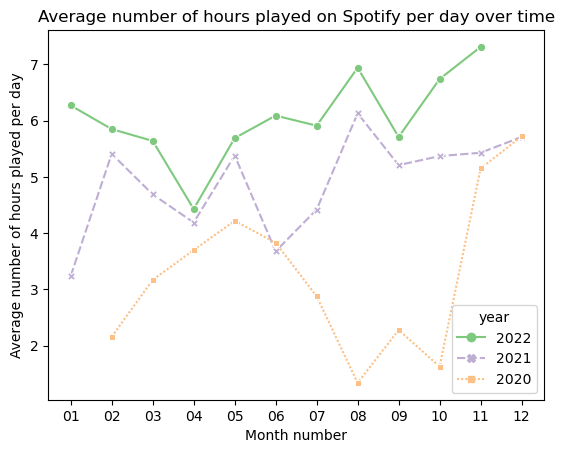

In [13]:
# Monthly evolution
listening_monthyear = \
    pd.read_sql('''
             SELECT year, month,
                   COUNT(*) AS nb_tracks,
                   SUM(min_played)/60 AS hours_played,
                   ROUND(SUM(min_played)/60/COUNT(DISTINCT date),2) AS hours_played_day
               FROM spotify
               GROUP BY 1,2
               ORDER BY 1 DESC, 2''', cnx)
listening_monthyear

lineplt = sns.lineplot(data = listening_monthyear, 
                 x= 'month', y = 'hours_played_day', 
                 hue = 'year', palette = 'Accent', style = 'year', markers = True).\
    set(title = 'Average number of hours played on Spotify per day over time')
plt.xlabel("Month number")
plt.ylabel("Average number of hours played per day")

### 4.2.2 Monthly evolutiBreakdown by media type (music vs podcasts)

In [60]:
# Interactive linechart : Hours played and number of sessions per day
listening_monthyear = pd.read_sql('''
             SELECT year, month, type,
                   COUNT(*) AS total_nb_sessions,
                   SUM(min_played)/60 AS hours_played_per_month,
                   ROUND(SUM(min_played)/60/COUNT(DISTINCT date),2) AS hours_played_day,
                   ROUND(COUNT(*)/COUNT(DISTINCT date),2) AS tracks_per_day
               FROM spotify
               WHERE type <> 'Error'
               GROUP BY 1,2,3
               ORDER BY 1 DESC, 2,3''', cnx)
listening_monthyear

# Define panel widgets
year_slider = pn.widgets.IntSlider(name = "Year slider", start = 2020, end = 2022, step = 1, value = 2020)

Y_axis = pn.widgets.RadioButtonGroup(
    name='Y axis', 
    options=['hours_played_day', 'tracks_per_day'],
    button_type='success'
)

#Interactive data
listening_monthyear["year"] = listening_monthyear["year"].astype(int)
listening_monthyear["month"] = listening_monthyear["month"].astype(int)
listening_monthyear_interact = listening_monthyear.interactive()

listening_monthyear_pipeline = (
    listening_monthyear_interact[listening_monthyear_interact.year == year_slider]
    .groupby(['year', 'month', 'type'])[Y_axis].mean()
    .to_frame()
    .reset_index()
    .sort_values(by=['year', 'month'])  
    .reset_index(drop=True)
)

linechart = listening_monthyear_pipeline.hvplot(x = 'month', by='type', y= Y_axis, line_width=2, legend = 'top_left',
                              title = 'Daily behavior: Avg. number of hours and tracks played per day',
                              color = ['#1DB954', '#eb6434'],
                              xticks = [1,2,3,4,5,6,7,8,9,10,11,12]
                              )
linechart

<div class="alert alert-block alert-info">
<b>Learnings:</b> <b>I started using Spotify in February 2020, just before the first French Covid19 lockdown was implemented (orange line).</b> During the lockdown, I used the service about 4 hours a day, and then almost completely stopped using it during the summer 2020 (end of the 1st lockdown). However, at the end of 2020, a second lockdown took place in France: I resumed using Spotify (up to 5 / 6 hours a day). After that, I never stopped using the app. In 2022, I listened to Spotify on average 4.5 to 7 hours a day. Summer and early Winter seem to be the two seasons where I use Spotify the most.

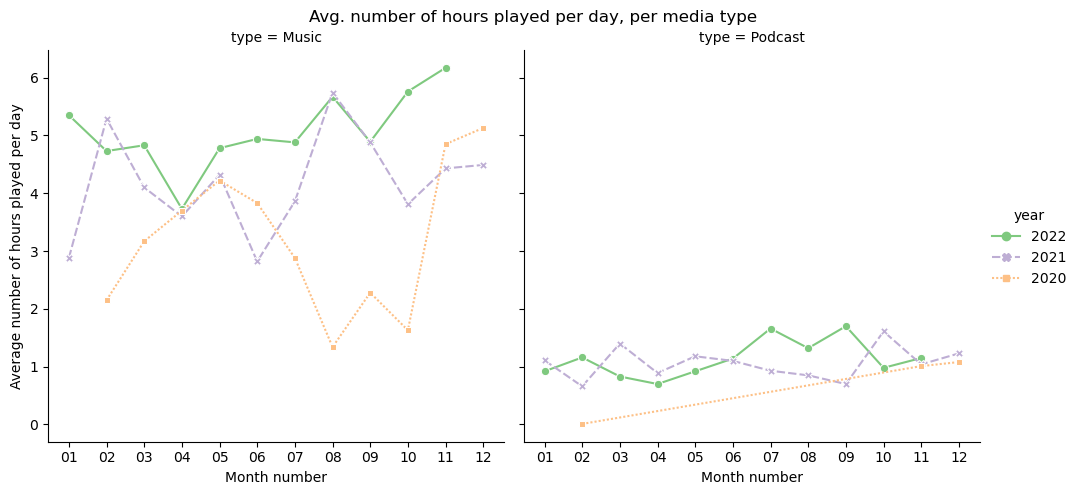

In [14]:
# Monthly evolution, by type of media
listening_monthyear_dev = \
    pd.read_sql('''
             SELECT year, month, type,
                   COUNT(*) AS nb_tracks,
                   SUM(min_played)/60 AS hours_played,
                   ROUND(SUM(min_played)/60/COUNT(DISTINCT date),2) AS hours_played_day
               FROM spotify
               WHERE type <> 'Error'
               GROUP BY 1,2,3
               ORDER BY 1 DESC, 2, 3''', cnx)
listening_monthyear_dev

relplt = sns.relplot(data = listening_monthyear_dev, 
                 x= 'month', y = 'hours_played_day', col = "type", kind = "line",
                 hue = 'year', palette = 'Accent', style = 'year', markers = True)
relplt.set_xlabels("Month number", clear_inner=False)
relplt.set_ylabels("Average number of hours played per day", clear_inner=False)
relplt.fig.suptitle('Avg. number of hours played per day, per media type')
relplt.fig.subplots_adjust(top=.9) # adjust the position of the global title

<div class="alert alert-block alert-info">
    <b>Learnings:</b> <b> My listening habits are very different depending on the media type. </b> For instance, my podcast consumption was almost non existent in 2020 (only 3 data points in the orange graph). In 2021 and 2022, I listened to podcasts about 1 hour a day, whatever the month considered. 

<br> On the other hand, my music consumption is much more time variant. It may vary from 2 hours/day to 7 hours/day on average. It is also worth noticing that summers 2020 (2 hours/day) and 2021 (6 hours/day) have complete opposite patterns.
<br> 

## 4.2. Listening habits

*Objective*: I want to find out...
* Time: When do I listen mostly Spotify? In public transports, at work, at home ? During the work week or during weekends?
* Device: Which device do I use most when using Spotify?
* Skipping actions: Do I tend to skip a lot of music tracks?

### 4.2.1 Day of week analysis

In [15]:
# DAY OF WEEK
#Time: When do I listen mostly Spotify? During the week or during weekends?
pd.set_option('display.max_rows', 10)
day_of_week = pd.read_sql( 
    '''
    SELECT 
        CASE 
            WHEN CAST(strftime('%w',date) AS INT) = 0 THEN '7.Sunday'
            WHEN CAST(strftime('%w',date) AS INT) = 1 THEN '1.Monday'
            WHEN CAST(strftime('%w',date) AS INT) = 2 THEN '2.Tuesday'
            WHEN CAST(strftime('%w',date) AS INT) = 3 THEN '3.Wednesday'
            WHEN CAST(strftime('%w',date) AS INT) = 4 THEN '4.Thursday'
            WHEN CAST(strftime('%w',date) AS INT) = 5 THEN '5.Friday'
            WHEN CAST(strftime('%w',date) AS INT) = 6 THEN '6.Saturday'
        END AS day_of_week,
        type,
        COUNT(*)/COUNT(DISTINCT date) AS avg_nb_tracks,
        ROUND(SUM(min_played)/COUNT(DISTINCT date),2)  AS avg_min_played
    FROM spotify 
    WHERE type <> 'Error'
    GROUP BY 1,2
    ORDER BY 1,2'''
    , cnx)
day_of_week

,day_of_week,type,avg_nb_tracks,avg_min_played
0,1.Monday,Music,101,275.40
1,1.Monday,Podcast,4,85.91
2,2.Tuesday,Music,109,280.49
3,2.Tuesday,Podcast,3,59.32
4,3.Wednesday,Music,105,288.19
...,...,...,...,...
9,5.Friday,Podcast,2,59.37
10,6.Saturday,Music,98,202.25
11,6.Saturday,Podcast,3,64.39
12,7.Sunday,Music,86,195.55


Text(0, 0.5, 'Number of listens')

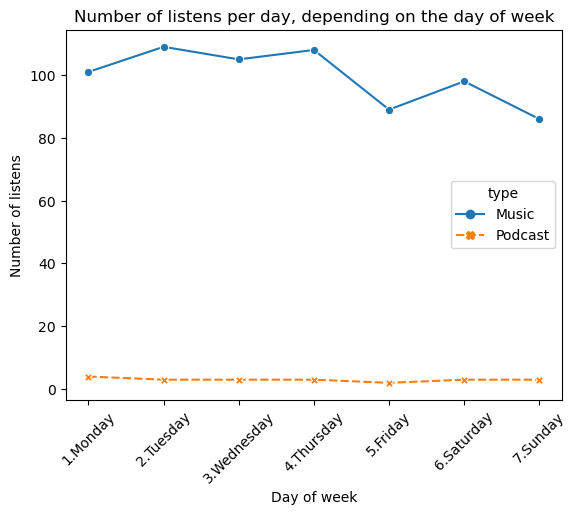

In [16]:
g= sns.lineplot(data = day_of_week.sort_values("day_of_week"), x = "day_of_week", y = "avg_nb_tracks", 
             hue = "type", style = "type", markers = True)
plt.xticks(rotation=45)
plt.title("Number of listens per day, depending on the day of week")
plt.xlabel("Day of week")
plt.ylabel("Number of listens")

<div class="alert alert-block alert-info">
    <b>Learnings:</b> <b>My consumption of podcasts is flat during the week. As far as music is concerned, my peak is at the beginning of the week (Monday to Thursday with 100+ tracks per day).</b> During Friday and the weekend, my number of tracks is down by about 10%. I believe it is because I am more physically active and perform many group activities on those days (hikes).

### 4.2.2 Time of the day analysis

In [17]:
# Time: When do I listen mostly Spotify? In public transports, at work, at home ?
pd.set_option('display.max_rows', 10)
hour_played = pd.read_sql( 
    '''
    SELECT 
        year,
        month,
        CASE 
            WHEN CAST(hour AS INT) BETWEEN 0 AND 7 OR CAST(hour AS INT)>=23 THEN 'NIGHT'
            WHEN CAST(hour AS INT) BETWEEN 8 AND 12 THEN 'MORNING'
            WHEN CAST(hour AS INT) BETWEEN 13 AND 18 THEN 'AFTERNOON'
            WHEN CAST(hour AS INT) BETWEEN 19 AND 22 THEN 'EVENING'
        END AS time_day, 
        hour,
        type,
        COUNT(*)/COUNT(DISTINCT date) AS avg_nb_tracks,
        ROUND(SUM(min_played)/COUNT(DISTINCT date),2)  AS avg_min_played
    FROM spotify 
    WHERE type <> 'Error'
    GROUP BY 1,2,3,4,5
    ORDER BY 1,2,4,3,5'''
    , cnx)
hour_played

,year,month,time_day,hour,type,avg_nb_tracks,avg_min_played
0,2020,02,MORNING,08,Music,1,4.70
1,2020,02,MORNING,09,Music,8,29.09
2,2020,02,MORNING,10,Music,11,40.69
3,2020,02,MORNING,11,Music,10,32.47
4,2020,02,MORNING,12,Music,8,23.80
...,...,...,...,...,...,...,...
998,2022,11,EVENING,21,Podcast,1,21.60
999,2022,11,EVENING,22,Music,9,5.38
1000,2022,11,EVENING,22,Podcast,1,22.81
1001,2022,11,NIGHT,23,Music,1,0.72


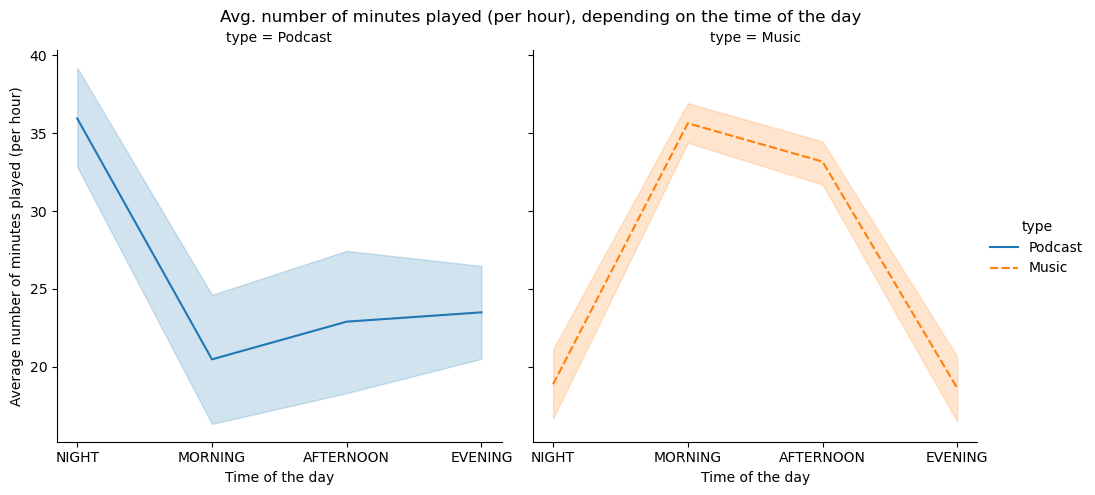

In [18]:
# Graph: 
    #For every hour in a given time period (morning, afternoon, evening, night), 
    #what is the average number of minutes played on Spotify (podcasts vs music)?
relplt = sns.relplot(data = hour_played.sort_values("hour"), x= 'time_day', y = 'avg_min_played', 
            kind = "line", col = "type", hue = "type", style = "type")

relplt.set_xlabels("Time of the day", clear_inner=False)
relplt.set_ylabels("Average number of minutes played (per hour)", clear_inner=False)
relplt.fig.suptitle('Avg. number of minutes played (per hour), depending on the time of the day')
relplt.fig.subplots_adjust(top=.9) # adjust the position of the global title

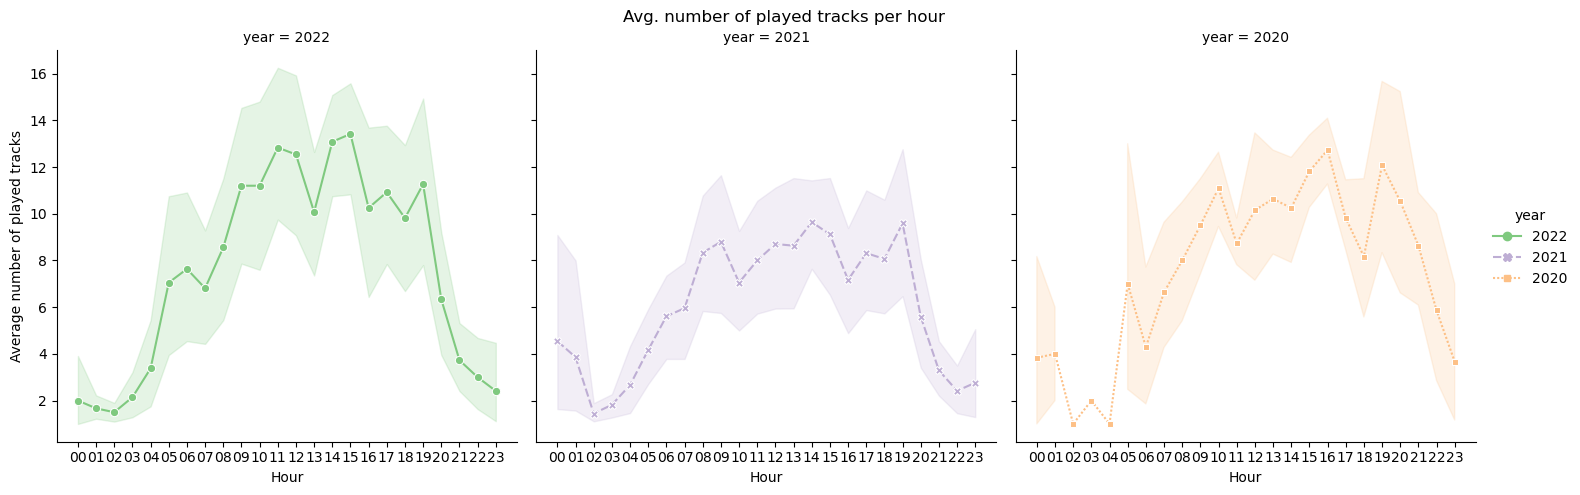

In [19]:
## Graph: Average number of listens per hour, per year
relplt = sns.relplot(data = hour_played.sort_values('hour'), 
                 x= 'hour', y = 'avg_nb_tracks', col = "year", kind = "line", 
                 hue = 'year', palette = 'Accent', style = 'year', markers = True)

relplt.set_xlabels("Hour", clear_inner=False)
relplt.set_ylabels("Average number of played tracks", clear_inner=False)
relplt.fig.suptitle('Avg. number of played tracks per hour')
relplt.fig.subplots_adjust(top=.9) # adjust the position of the global title

<div class="alert alert-block alert-info">
    <b>Learnings:</b> <b>I use Spotify mostly throughout the day, especially between 7AM and 7PM. </b>Indeed, I am listening to music in public transports and at work (about 10 tracks listened per hour). At night, my number of tracks is low (less than 4 tracks) because I tend to listen to podcasts which are longer than music tracks.

<br> I am a bit surprised that there are data displayed between 12AM and 6AM since I always sleep at those hours. Maybe it is because I forgot to turn off Spotify before sleeping.


### 4.2.3 Device analysis

Text(0, 0.5, 'Number of listenings')

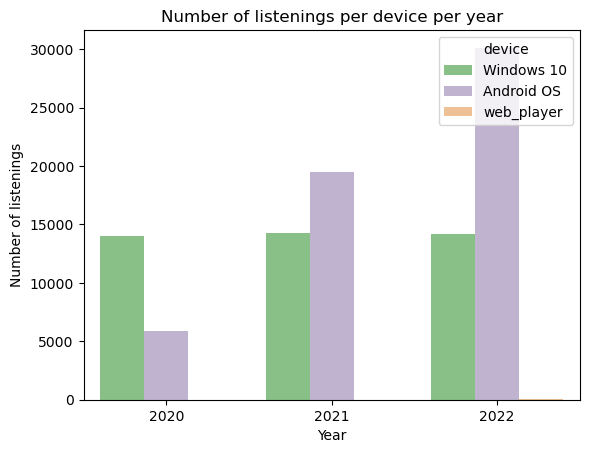

In [20]:
# Graph
g = sns.countplot(data=spotify_data.sort_values("year"), x="year", hue = "device", palette = "Accent").\
     set(title = "Number of listenings per device per year")
plt.xlabel("Year")
plt.ylabel("Number of listenings")

<div class="alert alert-block alert-info">
    <b>Learnings:</b> <b>I use mostly 2 types of device: the Spotify app on my smartphone (Android OS) and the Spotify desktop app (Windows 10).</b> It is very rare that I use the web player (usually it is when the desktop app did not run properly on my work laptop).
<br><br>
<b> My device habits changed a lot in the past 3 years.</b>. The number of tracks on the Spotify desktop version stayed constant over time (about 15,000 tracks per year). But, the number of tracks on the smartphone app exploded (from 5,000 to 30,000 tracks, i.e. x6 increase in only 2 years and a half). That way, in 2020, I was mostly a desktop Spotify user (75% of my total tracks). One year later, I used a bit more my smartphone than my personal computer to listen to Spotify music. In 2022, I use the smartphone app twice more than the desktop app.

### 4.2.4. Behavior analysis: skipped music tracks

*Objective*: Previous analyses showed that I consume more playlists and use more my smartphone than the desktop app when using Spotify. Does it induce that I skip more music tracks?

[Text(0.5, 0, 'Music track: Seconds played'), Text(0, 0.5, '%')]

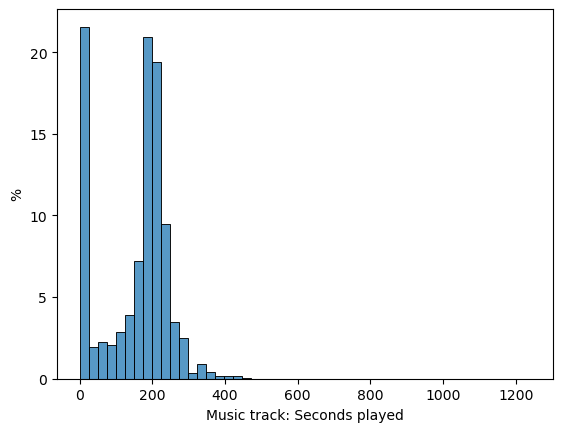

In [21]:
ax = sns.histplot(data = spotify_data[spotify_data["type"]=="Music"], x= 'sec_played', bins = 50, stat = "percent")
ax.set(xlabel='Music track: Seconds played', ylabel='%')

<div class="alert alert-block alert-info">
    <b>Learnings:</b> The above histogram shows that I skip about 20% of the music tracks over the whole period (cf. bar at 0 second played level).

In [22]:
# When does the skipping action occur, and for which device?
time_played = pd.read_sql('''
                          SELECT 
                              year,
                              device,
                              CASE 
                                  WHEN sec_played IS NULL THEN NULL
                                  WHEN sec_played <= 10 THEN '[0-10]'
                                  WHEN sec_played BETWEEN 11 AND 20 THEN '[11-20]'
                                  WHEN sec_played BETWEEN 21 AND 30 THEN '[21-30]'
                                  WHEN sec_played BETWEEN 31 AND 40 THEN '[31-40]'
                                  WHEN sec_played BETWEEN 41 AND 60 THEN '[41-60]'
                                  ELSE '[61 and more['
                              END AS sec_played_bins,
                          COUNT(*) AS nb_music_tracks
                          FROM spotify
                          WHERE type = 'Music'
                          GROUP BY 1,2,3
                          ORDER BY 1,2,3''',
                          cnx
)
time_played

,year,device,sec_played_bins,nb_music_tracks
0,2020,Android OS,[0-10],2686
1,2020,Android OS,[11-20],145
2,2020,Android OS,[21-30],69
3,2020,Android OS,[31-40],53
4,2020,Android OS,[41-60],102
...,...,...,...,...
32,2022,Windows 10,[21-30],70
33,2022,Windows 10,[31-40],71
34,2022,Windows 10,[41-60],143
35,2022,Windows 10,[61 and more[,13556


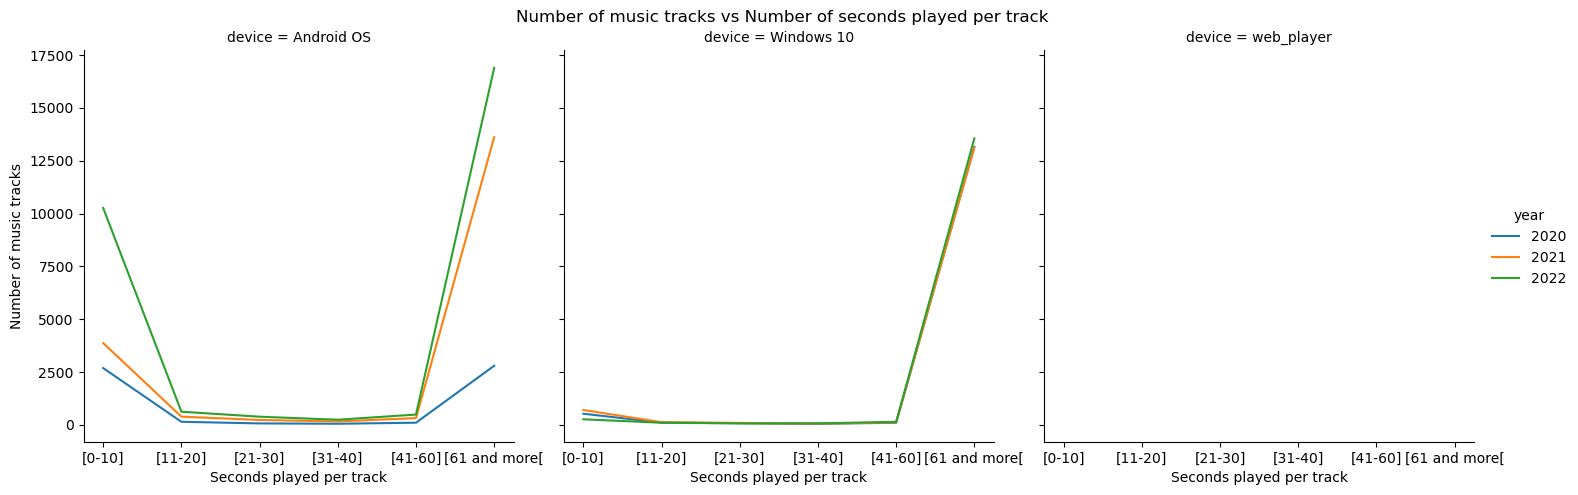

In [23]:
relplt = sns.relplot(data = time_played, x= "sec_played_bins", y="nb_music_tracks", 
            kind = "line", col = "device", hue = "year")
relplt.set_xlabels("Seconds played per track", clear_inner=False)
relplt.set_ylabels("Number of music tracks", clear_inner=False)
relplt.fig.suptitle('Number of music tracks vs Number of seconds played per track')
relplt.fig.subplots_adjust(top=.9) # adjust the position of the global title

<div class="alert alert-block alert-info">
    <b>Learnings:</b> <b>The above line charts show very different behaviors depending on the device type. </b> As far as the desktop app is concerned, I almost never skip any music track (flat line before the 40 seconds played), whatever the year considered. This may be because I use mostly the desktop app at work: I am focused on my work, and do not bother changing the music in the background. <br>
As far as the Spotify mobile app is concerned, I tend to skip a lot of music tracks. The skipping action usually occurs before 10 seconds. After that threshold, I seem to listen to the whole song.

In [24]:
# Skipping action vs time of the day ?
time_day_played = pd.read_sql('''
                          SELECT 
                              device,
                              hour,
                              CASE 
                                WHEN CAST(hour AS INT) BETWEEN 0 AND 7 OR CAST(hour AS INT)>=23 THEN '4. NIGHT'
                                WHEN CAST(hour AS INT) BETWEEN 8 AND 12 THEN '1. MORNING'
                                WHEN CAST(hour AS INT) BETWEEN 13 AND 18 THEN '2. AFTERNOON'
                                WHEN CAST(hour AS INT) BETWEEN 19 AND 22 THEN '3. EVENING'
                                END AS time_day, 
                              CASE 
                                  WHEN sec_played IS NULL THEN NULL
                                  WHEN sec_played <= 10 THEN 1
                                  ELSE 0
                              END AS skipped,
                          COUNT(*) AS nb_music_tracks
                          FROM spotify
                          WHERE type = 'Music'
                          GROUP BY 1,2,3,4
                          ORDER BY 1,2,3,4''',
                          cnx
)
time_day_played

,device,hour,time_day,skipped,nb_music_tracks
0,Android OS,00,4. NIGHT,0,19
1,Android OS,00,4. NIGHT,1,7
2,Android OS,01,4. NIGHT,0,9
3,Android OS,01,4. NIGHT,1,1
4,Android OS,02,4. NIGHT,0,9
...,...,...,...,...,...
90,Windows 10,23,4. NIGHT,1,8
91,web_player,08,1. MORNING,1,6
92,web_player,09,1. MORNING,1,6
93,web_player,14,2. AFTERNOON,1,18


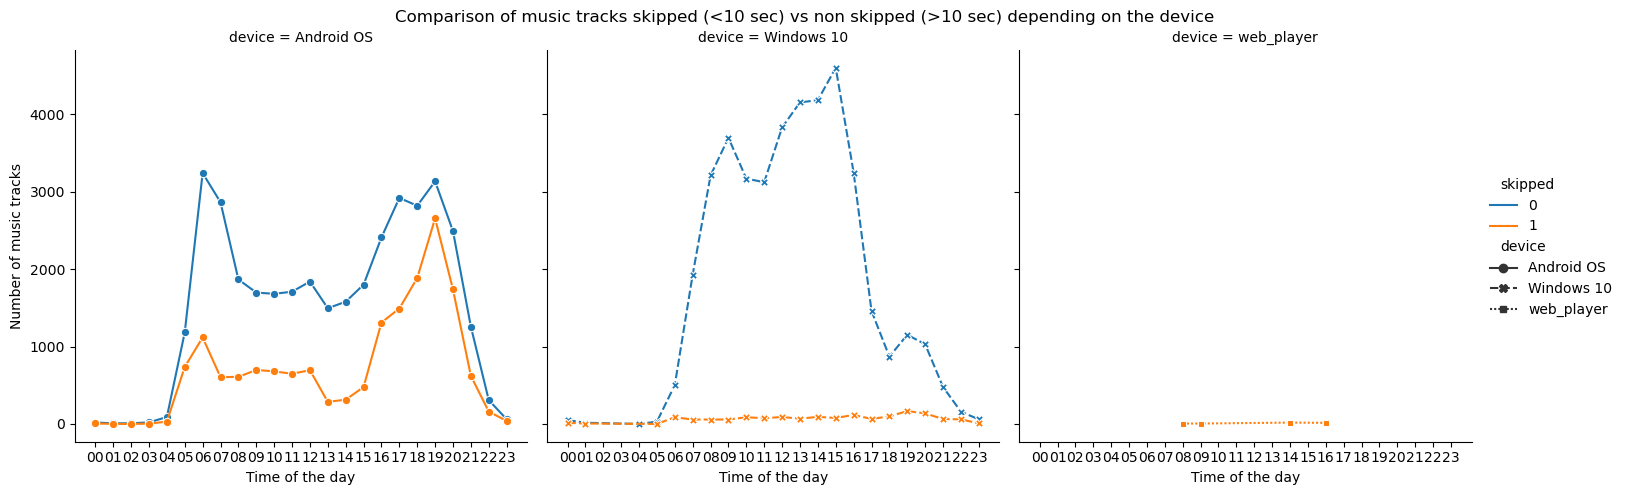

In [25]:
relplt = sns.relplot(data = time_day_played, x= "hour", y="nb_music_tracks", 
            kind = "line", col = "device", hue = "skipped", style = "device", markers = True)
relplt.set_xlabels("Time of the day", clear_inner=False)
relplt.set_ylabels("Number of music tracks", clear_inner=False)
relplt.fig.suptitle('Comparison of music tracks skipped (<10 sec) vs non skipped (>10 sec) depending on the device')
relplt.fig.subplots_adjust(top=.9) # adjust the position of the global title

<div class="alert alert-block alert-info">
    <b>Learnings:</b> The graphs above confirm the fact that I tend to not skip songs when using my computer. I am probably too busy focusing on my work to bother open the app interface and change the music track. On the contrary, when using my smartphone, I tend to skip a lot of songs, especially at the end of the day (cf. orange peak between 6PM and 8PM: the number of skipped songs is about the same as the number of non-skipped songs) when I am finishing work and going back home. Maybe it is for adjusting my mood from work to home. 11PM to 4AM are the hours I never skip any song: if some music is playing during those hours, it is probably because I am asleep and forgot to turn off the app. 

## 4.3. Favorite music tracks

*Objective*: I want to identify the top music tracks I listened every year. I also want to know whether my top ranking stays the same year over year.

In [54]:
# Interactive Tableau ranking
t2 = pd.read_sql('''
            SELECT 
                subquery.*,
                COUNT(*) OVER (PARTITION BY spotify_track_uri) AS song_appearance_top10,
                COUNT(*) OVER (PARTITION BY artist_name) AS artist_appearance_top10
            FROM (
                -- I compute the rank (and allow the possibility of ex aequos)
                SELECT sessions.*,
                    DENSE_RANK() OVER (PARTITION BY year ORDER BY nb_sessions DESC) AS ranking
                
                FROM ( 
                -- For each year, I compute the total number of sessions for each music track
                    SELECT 
                         year, 
                         spotify_track_uri, 
                         track_name, 
                         artist_name, 
                         COUNT(*) AS nb_sessions
                    FROM spotify
                    WHERE track_name IS NOT NULL
                    GROUP BY 1,2,3,4
                    ORDER BY year ASC, nb_sessions DESC
                    ) sessions
                ) subquery
                WHERE ranking <= 10
                ORDER BY year ASC, nb_sessions DESC''', cnx)
t2

# Define panel widgets
year_slider = pn.widgets.IntSlider(name = "Year slider", start = 2020, end = 2022, step = 1, value = 2020)
top_n =  pn.widgets.IntSlider(name = "Top N", start = 1, end = 10, step = 1, value = 10)

# Formatters
tabulator_formatters = {
    'artist_appearance_top10': {'type': 'progress', 'max': 5},
    'song_appearance_top10': {'type': 'tickCross'},
    'track_name': {'type':"textarea"}
}


#Interactive data
t2["year"] = t2["year"].astype(int)
t2_interact = t2.interactive()

t2_pipeline = (
    t2_interact[(t2_interact.year == year_slider) & (t2_interact.ranking <= top_n)]
    .groupby(['ranking', 'year', 'artist_name','track_name', 'spotify_track_uri', 'song_appearance_top10', 'artist_appearance_top10'])['nb_sessions'].sum()
    .to_frame()
    .reset_index()
    .sort_values(by=['year', 'ranking'])  
    .reset_index(drop=True)
)

top_tracks_table = t2_pipeline.pipe(pn.widgets.Tabulator, pagination='remote', page_size = top_n, 
                                    sizing_mode='stretch_width', theme = 'simple', show_index = False,
                                   formatters=tabulator_formatters) 
top_tracks_table

<div class="alert alert-block alert-info">
    <b>Learning:</b> <b> My top 10 tracks are mostly made of Kpop songs every year. Still, these songs do not last in the top rankings:</b> no song is found in the top 10 for several years. <br>
<br>
<b>However, some artists appear quite consistently in my top 10 songs (e.g. Wonho appears 4 times, K/DA 3 times and Dreamcatcher twice). More surprisingly, my top Kpop songs are not necessarily sung by the most famous Kpop artists (e.g. no BTS or Blackpink).</b> It seems that I fell in love with specific songs produced by smaller artists. <br>
<br>
<b>Some titles in the top 10 may be misleading. Indeed, even if some songs do not belong to the Kpop genre, I discovered these songs through Kpop dance. </b>For instance, I discovered Post Malone' 'Motley Crew' song (2nd most listened song in 2021) thanks to the Hyunjin's dance cover on Studio Choom. I fell in love with BewhY's 'Side by Side' song (3nd most listened song in 2021) because of Netflix 1M dance cover. Finally, regarding K/DA, I do not play League of Legends but I really like the MVs featuring famous girl K-rappers.

## 4.3 Favorite artists

*Objective*: I want to identify the top artists I listened to every year. I also want to know whether my top ranking stays the same year over year.

In [55]:
pd.set_option('display.max_rows', 500)
top_10_artists = pd.read_sql('''
            SELECT 
                year, ranking, artist_name, nb_sessions, nb_artist_tracks, 
                nb_sessions / nb_artist_tracks AS avg_session_track,
                COUNT(*) OVER (PARTITION BY artist_name) AS artist_appearance_top10
            FROM (
                -- I compute the rank (and allow the possibility of ex aequos)
                SELECT sessions.*,
                    DENSE_RANK() OVER (PARTITION BY year ORDER BY nb_sessions DESC) AS ranking
                
                FROM ( 
                -- For each year, I compute the total number of sessions for each artist
                    SELECT 
                         year, 
                         artist_name, 
                         COUNT(DISTINCT spotify_track_uri) AS nb_artist_tracks,
                         COUNT(*) AS nb_sessions
                    FROM spotify
                    WHERE track_name IS NOT NULL
                    GROUP BY 1,2
                    ORDER BY year ASC, nb_sessions DESC
                    ) sessions
                ) subquery
                WHERE ranking <= 10 
                ORDER BY year ASC, nb_sessions DESC''', cnx)
top_10_artists

# Define panel widgets
year_slider = pn.widgets.IntSlider(name = "Year slider", start = 2020, end = 2022, step = 1, value = 2020)
top_n =  pn.widgets.IntSlider(name = "Top N", start = 1, end = 10, step = 1, value = 10)
Y_axis = pn.widgets.RadioButtonGroup(
    name='Y axis', 
    options=['nb_sessions', 'nb_artist_tracks', 'avg_session_track'],
    button_type='success'
)

# Formatters
tabulator_formatters = {
    'artist_appearance_top10': {'type': 'progress', 'max': 5}
}

#Interactive data
top_10_artists["year"] = top_10_artists["year"].astype(int)
top_10_artists_interact = top_10_artists.interactive()

top_10_artists_pipeline = (
    top_10_artists_interact[(top_10_artists_interact.year == year_slider) & (top_10_artists_interact.ranking <= top_n)]
    .groupby(['ranking', 'year', 'artist_name','artist_appearance_top10'])[Y_axis].sum()
    .to_frame()
    .reset_index()
    .sort_values(by=['year', 'ranking'])  
    .reset_index(drop=True)
)

top_10_artists_table = top_10_artists_pipeline.pipe(pn.widgets.Tabulator, pagination='remote', page_size = top_n, 
                                    sizing_mode='stretch_width', theme = 'simple', show_index = False,
                                   formatters=tabulator_formatters) 
top_10_artists_table

<div class="alert alert-block alert-info">
    <b>Learning:</b> <b> My top 10 artists differ quite a lot from the artists available in my top 10 songs ranking.  </b><br>
<br>
<b>First, very famous Kpop groups like BTS, TWICE, Stray Kids or EXO are in the top artists ranking (which was not the case in the top 10 songs ranking).</b> Indeed, for these artists, I tended to listen to their whole albums, not just one or two songs on loop. For instance, in 2020, I listened to 94 BTS songs, with an average of 8 plays per song. The same year, I listened to only 5 K/DA songs, with an average of 44 plays per song. That is why K/DA is my top 10 songs in 2020, and not BTS - although BTS is my 2nd most popular artist in 2020.
<br>
<br>    
<b>One thing to notice in 2022 is that there are less Kpop artists in top 10.</b>There are some artists in the 'epic' genre like 2WEI and Two Steps from Hell, as well as some popular western artists like Tiësto and David Guetta. I believe it is because I am listening to more playlists on Spotify that made me discover new songs outside my Kpop comfort zone.
<br>


## 4.4 Favorite podcasts

*Objective*: I want to identify the top podcasts I listened to every year. I also want to know whether my top ranking stays the same year over year.

In [58]:
top_5_podcasts = pd.read_sql('''
            SELECT 
                finale.*,
                COUNT(*) OVER (PARTITION BY episode_show_name) AS show_appearance_top5
            FROM (
                SELECT subquery.*,
                    DENSE_RANK() OVER (PARTITION BY year ORDER BY nb_sessions DESC) AS ranking
                
                FROM ( 
                -- For each year, I compute the total number of sessions for each music track
                    SELECT 
                         year, 
                         episode_show_name, 
                         COUNT(*) AS nb_sessions
                    FROM spotify
                    WHERE type= 'Podcast'
                    GROUP BY 1,2
                    ) subquery
                    ORDER BY year ASC, nb_sessions DESC
                ) finale
                WHERE RANKING <= 5
                ORDER BY year, ranking''', cnx)
top_5_podcasts


# Define panel widgets
year_slider = pn.widgets.IntSlider(name = "Year slider", start = 2020, end = 2022, step = 1, value = 2020)
top_n =  pn.widgets.IntSlider(name = "Top N", start = 1, end = 5, step = 1, value = 5)

# Formatters
tabulator_formatters = {
    'show_appearance_top5': {'type': 'progress', 'max': 5}
}

#Interactive data
top_5_podcasts["year"] = top_5_podcasts["year"].astype(int)
top_5_podcasts_interact = top_5_podcasts.interactive()

top_5_podcasts_pipeline = (
    top_5_podcasts_interact[(top_5_podcasts_interact.year == year_slider) & (top_5_podcasts_interact.ranking <= top_n)]
    .groupby(['ranking', 'year', 'episode_show_name','show_appearance_top5'])['nb_sessions'].sum()
    .to_frame()
    .reset_index()
    .sort_values(by=['year', 'ranking'])  
    .reset_index(drop=True)
)

top_5_podcasts_table = top_5_podcasts_pipeline.pipe(pn.widgets.Tabulator, pagination='remote', page_size = top_n, 
                                    sizing_mode='stretch_width', theme = 'simple', show_index = False,
                                   formatters=tabulator_formatters) 
top_5_podcasts_table


<div class="alert alert-block alert-info">
    <b>Learning:</b> <b>It turns out that I listen mostly to French speaking podcasts. Many are business or career oriented </b>, like "Vocation" (a guest is interviewed to present his / her job to a students and young graduates audience), "Dans la tête d'un PM" (interviews of product managers), "Guerres de Business" (story telling about business wars between giant companies), "Case Interview Prep & management Consulting" (management consulting), etc. I also listen to stories ("Les Pieds sur terre"), news ("La Story") and humor ("Le Moment Meurice").
<br><br>
One thing to notice is that my top 5 podcast shows are quite consistent over time. I tend to listen to the same shows year after year (with some exceptions). Moreover,  I listen to far more episodes in 2022 than in 2020. For instance, in 2020, "Maker" and "Generation XX" were part of my top 5 ranking in 2020 but I listened to each show only twice ! 

## 5. Conclusion

Thanks to this case study, I learnt that:
* <b>Spotify has become part of my daily life</b>. I use the service all day long: at home, at work, in the public transports or in the evening before going to sleep. That way, in 2022, I am used to listening to Spotify about 6 hours a day. This can be achieved thanks to the mobile app - that I use now much more than the desktop version.
* <b>Over the years, Spotify allowed me to diversify my horizons.</b> Certainly, I skip about 20% of the music tracks but my daily listening habits have changed: I listen to more podcasts and diverse artists thanks to Spotify playlists.

## 6. Interactive dashboard summarizing all insights

In [ ]:
# Pre-processing: Make the sotify_data dataframe interactive
spotify_data["year"] = spotify_data["year"].astype(int)
spotify_data["hour"] = spotify_data["hour"].astype(int)
spotify_data["time_of_day"] = np.where((spotify_data["hour"] <8) | (spotify_data["hour"] >=23), 'NIGHT',
                                       np.where((spotify_data["hour"] >=8) & (spotify_data["hour"] <=12), 'MORNING',
                                                np.where((spotify_data["hour"] >=13) & (spotify_data["hour"] <=18), 'AFTERNOON',
                                                'EVENING')
                                               )
                                      )
spotify_data["skipped"] = np.where(spotify_data["ms_played"]<= 10, 1, 0)

In [ ]:
# Define panel widgets
year_slider = pn.widgets.IntSlider(name = "Year slider", start = 2020, end = 2022, step = 1, value = 2020)

Y_axis = pn.widgets.RadioButtonGroup(
    name='Y axis', 
    options=['hours_played_day', 'tracks_per_day'],
    button_type='success'
)

In [ ]:
# Interactive linechart : Hours played and number of sessions per day
t1 = pd.read_sql('''
             SELECT year, month, type,
                   COUNT(*) AS total_nb_sessions,
                   SUM(min_played)/60 AS hours_played_per_month,
                   ROUND(SUM(min_played)/60/COUNT(DISTINCT date),2) AS hours_played_day,
                   ROUND(COUNT(*)/COUNT(DISTINCT date),2) AS tracks_per_day
               FROM spotify
               WHERE type <> 'Error'
               GROUP BY 1,2,3
               ORDER BY 1 DESC, 2,3''', cnx)
t1

#Interactive data
t1["year"] = t1["year"].astype(int)
t1["month"] = t1["month"].astype(int)
t1_interact = t1.interactive()

t1_pipeline = (
    t1_interact[t1_interact.year == year_slider]
    .groupby(['year', 'month', 'type'])[Y_axis].mean()
    .to_frame()
    .reset_index()
    .sort_values(by=['year', 'month'])  
    .reset_index(drop=True)
)

linechart = t1_pipeline.hvplot(x = 'month', by='type', y= Y_axis, line_width=2, legend = 'top_left',
                              title = 'Daily behavior: Avg. number of hours and tracks played per day',
                              color = ['#1DB954', '#eb6434'],
                              xticks = [1,2,3,4,5,6,7,8,9,10,11,12]
                              )
linechart

In [ ]:
# Interactive hist
spot_interact = spotify_data.interactive()

t3_pipeline = (
    spot_interact[spot_interact.year == year_slider]
    .groupby(['year', 'month', 'device'])['spotify_track_uri'].count()
    .to_frame()
    .reset_index()
    .sort_values(by=['year', 'month'])  
    .reset_index(drop=True)
)
t3_pipeline

hist = t3_pipeline.hvplot(x ='month', y='spotify_track_uri', kind = "bar", by = "device", 
                          rot=90, #xaxis = None,
                          color = ['#1DB954', '#eb6434'],
                          xlabel = 'Month / Device', 
                          ylabel = "Number of tracks", title = 'Number of tracks played per month, per device type')
hist

In [ ]:
# Final dashboard
logo = pn.pane.PNG('Spotify_logo_png.png', sizing_mode='scale_both')

title = '<h2>Margot | Spotify Wrapped dashboard</h2>'

desc = pn.pane.Markdown("""
    Every December since 2016, Spotify users discover their Spotify Wrapped. 
    The latter provides a compilation of data about their activity on the platform over the past year: top artists, top songs, top genres, etc. 
    <br> The objective here is to reproduce most insights from Spotify Wrapped using Python and SQL.
    <br><br> Author: Margot MARCHAIS--MAURICE""", width=250)

year_slider = pn.widgets.IntSlider(name = "Year slider", start = 2020, end = 2022, step = 1, value = 2020)

template = pn.template.MaterialTemplate(
    title='Margot | Spotify Wrapped dashboard',
)

template.sidebar.append(logo)
template.sidebar.append(desc.clone(width=250, margin=(10, 5)))
template.sidebar.append(year_slider)

template.main.append(
    pn.Column(
        pn.Row('Linechart'),
        pn.Row(linechart),
        pn.Row('Histogram'),
        pn.Row(hist),
        pn.Row(top_tracks_table)
    )
)
template.servable();

In [ ]:
import spotipy.util as util

username = 'Margotmmm' #input your username
client_id ='94494b1f0ce8414aad28b853b2e68acb' # input your client_id
client_secret = 'a87bd51a865c42178957691111cd3f43'
redirect_uri = 'http://localhost:7777/callback'
scope = 'user-read-recently-played'

token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri=redirect_uri)
# Now you can finally authorize your app. Once you click on Agree, 
# you will be taken to the Redirect URI, which may well be a nonexistent page. 
# Just copy the address and paste it in your Python console.

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id="94494b1f0ce8414aad28b853b2e68acb",
                                               client_secret="a87bd51a865c42178957691111cd3f43",
                                               redirect_uri="http://localhost:7777/callback",
                                               scope="user-library-read"))

results = sp.current_user_saved_tracks()
for idx, item in enumerate(results['items']):
    track = item['track']
    print(idx, track['artists'][0]['name'], " – ", track['name'])

In [ ]:
import spotipy